# Feature Engineering Project <br/> Concrete Strength Prediction
### Thomas Webb <br/> November 11, 2020

##### `Objective:` 
Create a classification model that will predict the concrete strength using the data available in file "concrete.csv". Apply feature engineering and model tuning techniques to obtain 85% to 95% accuracy.

The data for this project is available at https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/.

# Import Libraries and Data

In [571]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, accuracy_score, roc_curve
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor

import warnings
warnings.filterwarnings('ignore')

In [572]:
# Import data from .csv and check for dimensions and missing information.
data = pd.read_csv('concrete.csv')

In [573]:
data.describe()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


##### `Insights:`
**'slag'**, **'ash'**, and **'superplastic'** all appear to have quite a few 0 values. When we consider that within the realm of reality, we know that this is possible, so it is nothing to be concerned with.

In [574]:
# Check data types and number of entries
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cement        1030 non-null   float64
 1   slag          1030 non-null   float64
 2   ash           1030 non-null   float64
 3   water         1030 non-null   float64
 4   superplastic  1030 non-null   float64
 5   coarseagg     1030 non-null   float64
 6   fineagg       1030 non-null   float64
 7   age           1030 non-null   int64  
 8   strength      1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


In [575]:
# Check for null or missing values
data.isnull().sum()

cement          0
slag            0
ash             0
water           0
superplastic    0
coarseagg       0
fineagg         0
age             0
strength        0
dtype: int64

# Exploratory Data Analysis

### Univariate Analysis

In [576]:
skewdf = pd.DataFrame(data.skew(axis = 0, skipna = True), columns = ['Skew'])
skewdf.sort_values(by=['Skew'])

,Skew
fineagg,-0.253010
coarseagg,-0.040220
water,0.074628
strength,0.416977
cement,0.509481
ash,0.537354
slag,0.800717
superplastic,0.907203
age,3.269177


##### ` Insights:`
**'age'** is notably more skewed than the rest of the column variables.

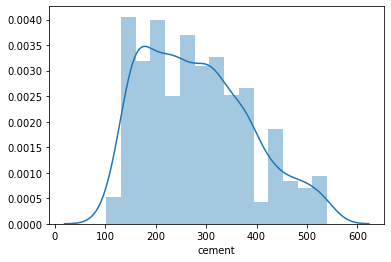

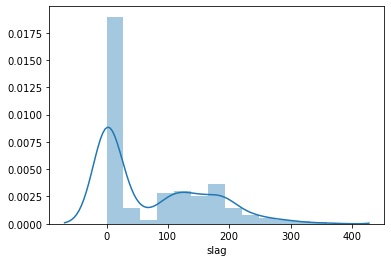

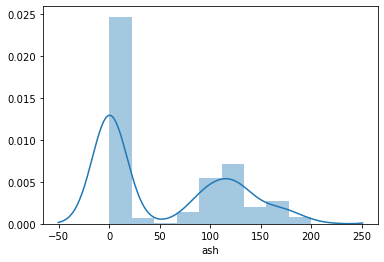

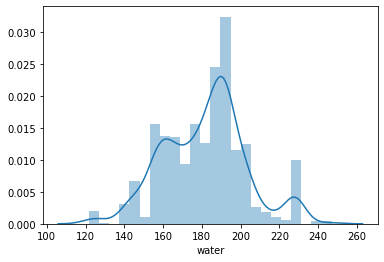

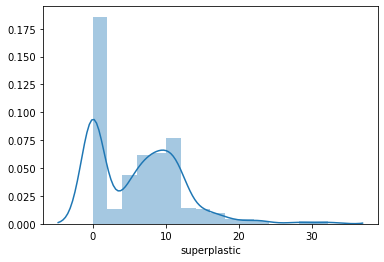

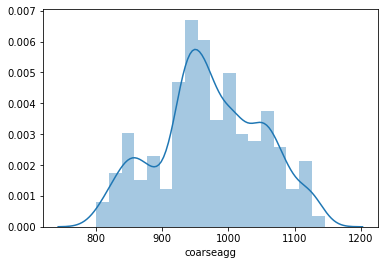

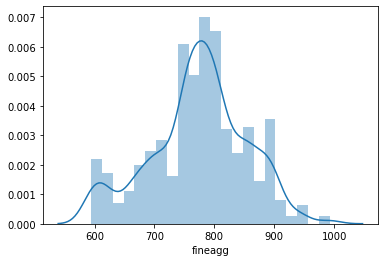

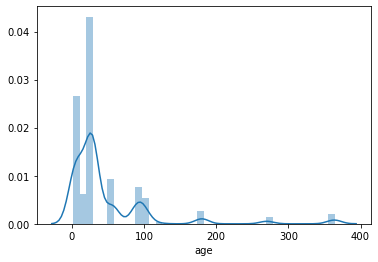

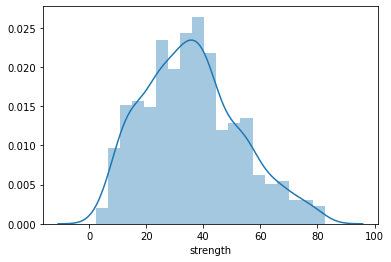

In [577]:
# Histograms that show distribution of each variable
for i in data.columns:
    sns.distplot(data[i])
    plt.show()

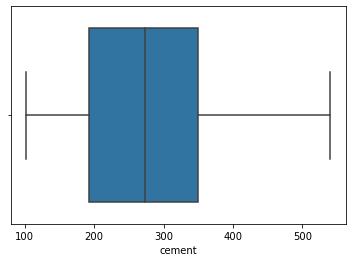

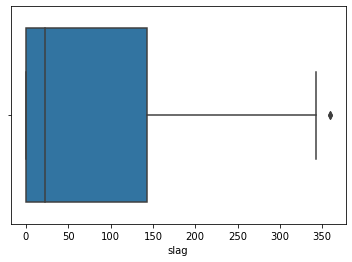

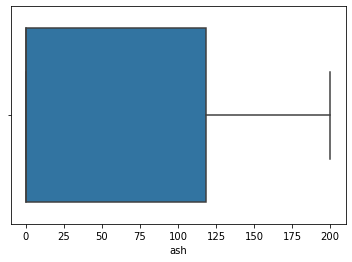

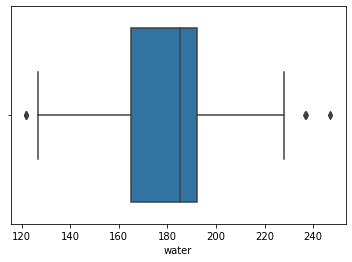

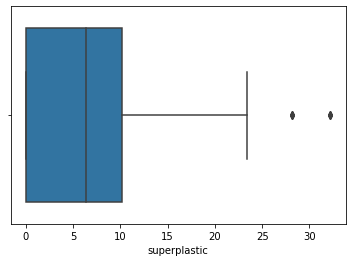

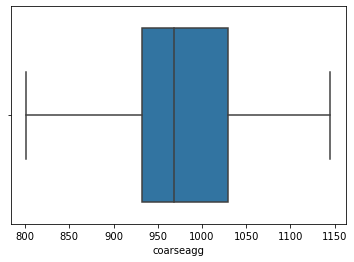

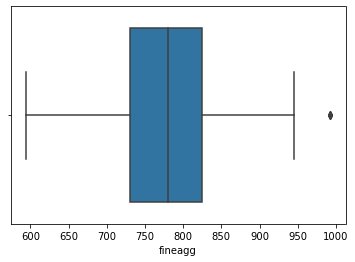

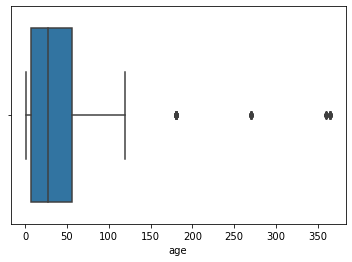

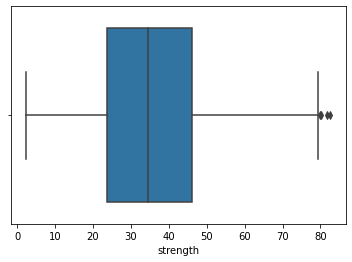

In [578]:
# Use boxplots to check for median values and outliers
for i in data.columns:
    sns.boxplot(data[i])
    plt.show()

##### `Insights:`
Consider dropping the entries that result in outliers within the columns **'age'**, **'strength'**, **'fineagg'**, **'superplastic'**, **'water'**, and **'slag'**.

### Bivariate Analysis

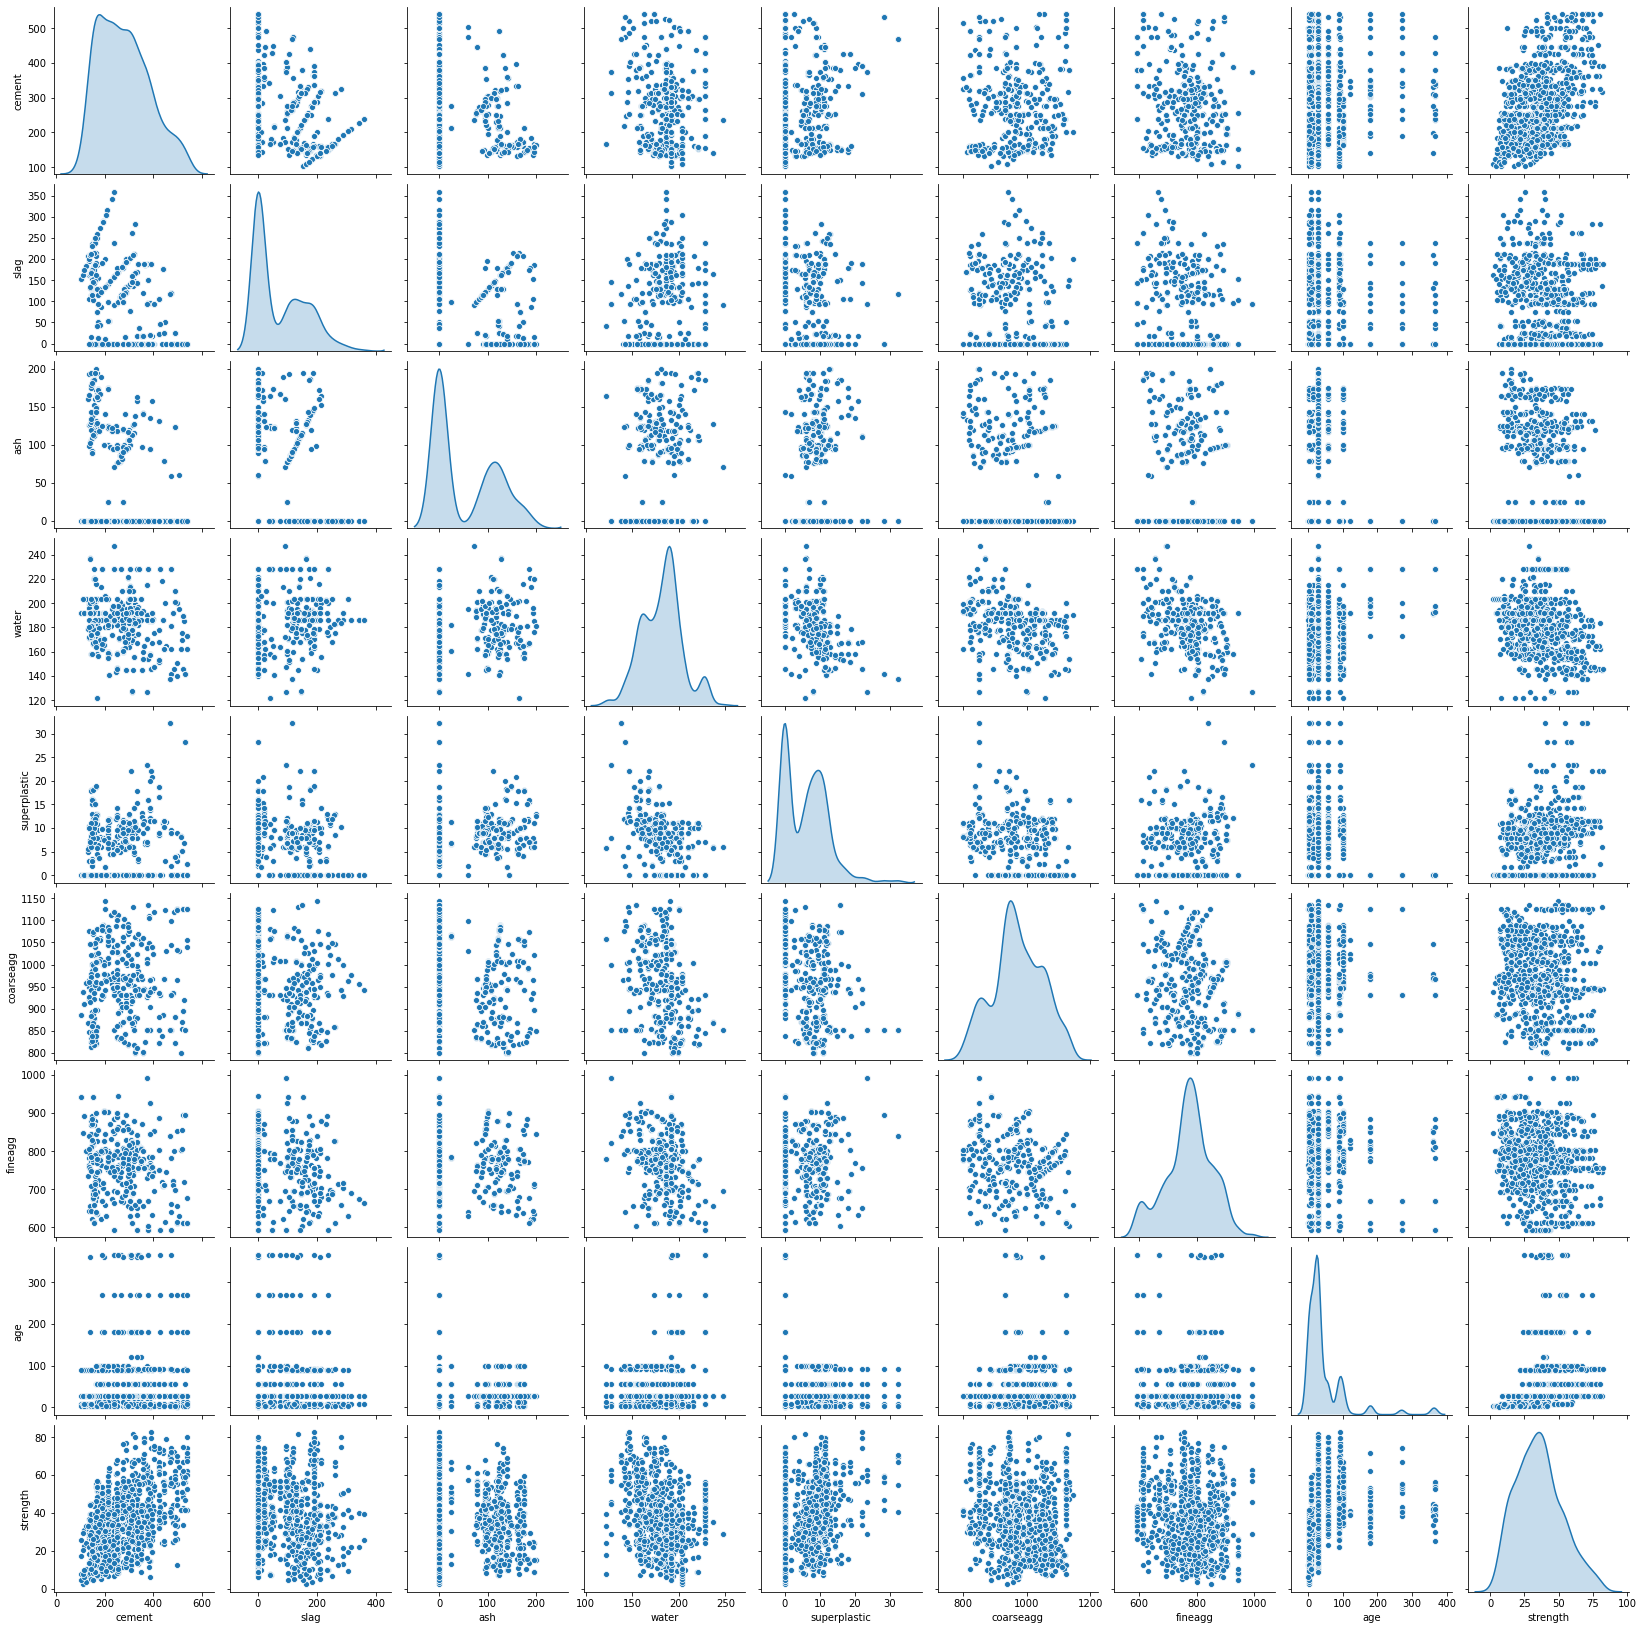

In [579]:
sns.pairplot(data=data, diag_kind='kde')

##### `Insights:`
- **'age'** appears to be more heavily skewed to the left than the other variables.
- A loose correlation can be seen in the scatterplot between **'cement'** and **'strength'**.

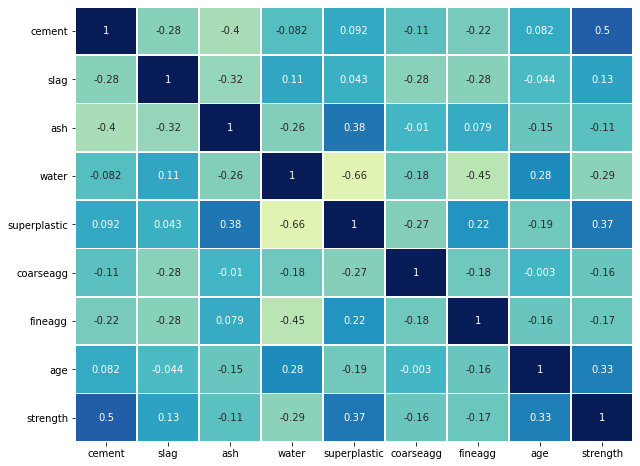

In [580]:
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(),
            annot=True,
            linewidths=.5,
            center=0,
            cbar=False,
            cmap="YlGnBu")
plt.show()

##### `Insights:`
**'cement'**, **'superplastic'**, and **'age'** seem to be more highly correlated with **'strength'** than any other variable.

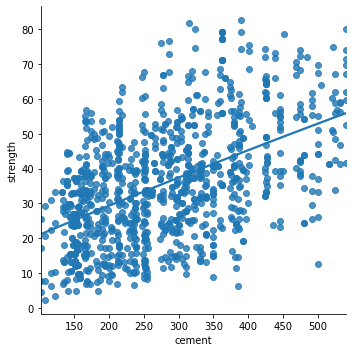

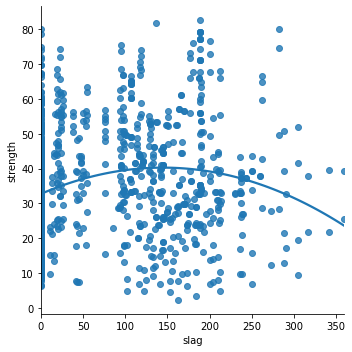

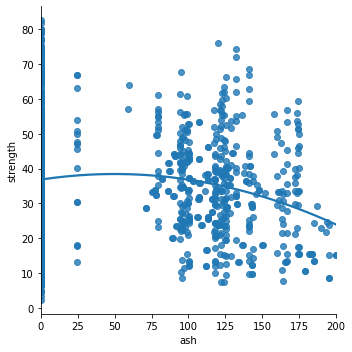

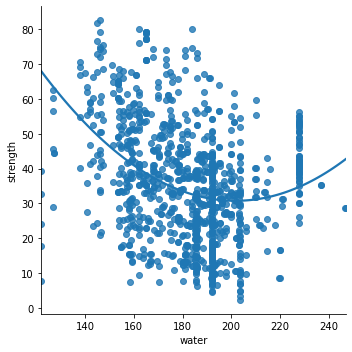

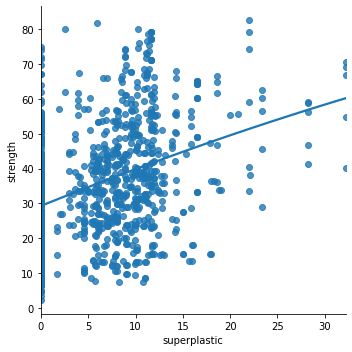

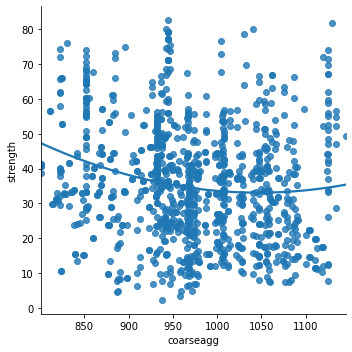

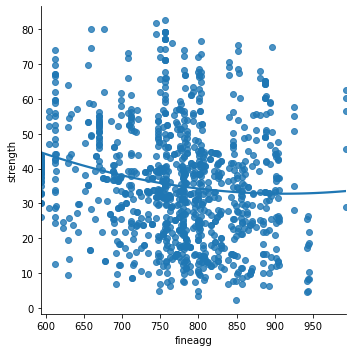

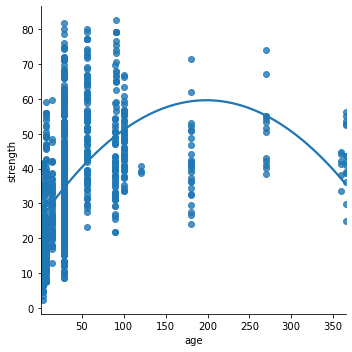

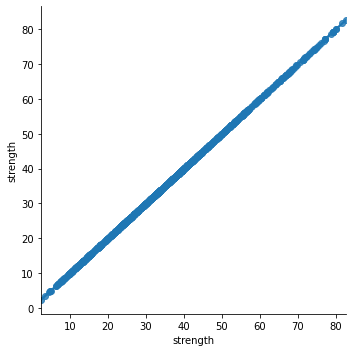

In [581]:
# Looking at these bi-variate simple regression lines (2nd-order) can show the real relationships between variable and strength
for i in data.columns:
    sns.lmplot(data=data, x=i, y="strength", order=2, ci=None)
    plt.show()

In [582]:
# Feature Engineering Techniques
    # Drop outliers (data points that can misrepresent) 
    # Drop irelevant information (little or no predictive power)
    # What can we create?
    # Standardize the dataset by scaling all columns
    # Allow polynomial model features to represent non-linear interactions between variables
    # Lasso/Ridge Regression for feature selection

In [584]:
# Instantiate kfold class for cross validation to evaluate model performance
# In our analysis we will use k = 5, and this will remain constant across all iterations of our models.

num_folds = 5
seed = 22
kfold = KFold(n_splits=num_folds, random_state=seed)

# Baseline Models

##### `Explanation:`
The following five regression models will be executed **without** any feature engineering or parameter tuning. This will be done and saved in order to show a baseline, and get an accurate sense of the impact of feature engineering and parameter tuning on the cross-validation accuracy of the models. We will compare these accuracy scores with the rest in the conclusion.

As the target variable outcomes are not binary, this is not a classification problem, but rather, a regression problem. The algorithms that have been chosen to fit our data with are: **Linear Regression**, **Decision Tree Regressor**, **Random Forest Regressor**, **AdaBoost Regressor**, and **Bagging Regressor**.

In [585]:
# Get the data ready for split
X = data.drop('strength', axis=1)
y = data[['strength']]

In [586]:
# Split the data into a training and testing set, with a 70/30 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [587]:
X_train.shape

(721, 8)

##### Linear Regression

In [588]:
# Create simple linear regression model
linear = LinearRegression()
results = cross_val_score(linear, X_train, y_train, cv=kfold)
print(results)
print("%.3f%% (%.3f%%)" % (results.mean()*100, results.std()*100))

[0.61083863 0.56664958 0.58960131 0.62448079 0.57978706]
59.427% (2.089%)


In [589]:
# Create DataFrame to store k-fold cross-validation accuracy scores
base_resultsDf = pd.DataFrame({'Method':['Linear Regression'], 'Baseline CV Accuracy': "%.3f%% (%.3f%%)" % (results.mean()*100, results.std()*100)})
base_resultsDf = base_resultsDf[['Method', 'Baseline CV Accuracy']]

##### Decision Tree

In [590]:
# Create simple decision tree model
dtree = DecisionTreeRegressor(random_state = 1)
results = cross_val_score(dtree, X_train, y_train, cv=kfold)
print(results)
print("%.3f%% (%.3f%%)" % (results.mean()*100, results.std()*100))

[0.82212348 0.74105832 0.74669224 0.82799255 0.76998773]
78.157% (3.685%)


In [591]:
# Add k-fold cross validation accuracy scores to results DataFrame
tempResultsDf = pd.DataFrame({'Method':['Decision Tree'], 'Baseline CV Accuracy': "%.3f%% (%.3f%%)" % (results.mean()*100, results.std()*100)})
base_resultsDf = pd.concat([base_resultsDf, tempResultsDf])
base_resultsDf = base_resultsDf[['Method', 'Baseline CV Accuracy']]

##### Random Forest

In [592]:
# Create simple random forest model
forest = RandomForestRegressor(random_state = 1)
results = cross_val_score(forest, X_train, y_train, cv=kfold)
print(results)
print("%.3f%% (%.3f%%)" % (results.mean()*100, results.std()*100))

[0.90274461 0.87015912 0.83748479 0.9054952  0.8988713 ]
88.295% (2.602%)


In [593]:
# Add k-fold cross validation accuracy scores to results DataFrame
tempResultsDf = pd.DataFrame({'Method':['Random Forest'], 'Baseline CV Accuracy': "%.3f%% (%.3f%%)" % (results.mean()*100, results.std()*100)})
base_resultsDf = pd.concat([base_resultsDf, tempResultsDf])
base_resultsDf = base_resultsDf[['Method', 'Baseline CV Accuracy']]

##### AdaBoost

In [594]:
# Create simple AdaBoost model
ada = AdaBoostRegressor(random_state = 1)
results = cross_val_score(ada, X_train, y_train, cv=kfold)
print(results)
print("%.3f%% (%.3f%%)" % (results.mean()*100, results.std()*100))

[0.81092947 0.75180007 0.75953554 0.74468907 0.81827118]
77.705% (3.111%)


In [595]:
# Add k-fold cross validation accuracy scores to results DataFrame
tempResultsDf = pd.DataFrame({'Method':['AdaBoost'], 'Baseline CV Accuracy': "%.3f%% (%.3f%%)" % (results.mean()*100, results.std()*100)})
base_resultsDf = pd.concat([base_resultsDf, tempResultsDf])
base_resultsDf = base_resultsDf[['Method', 'Baseline CV Accuracy']]

##### Bagging

In [596]:
# Create simple bagging model
bag = BaggingRegressor(random_state = 1)
results = cross_val_score(bag, X_train, y_train, cv=kfold)
print(results)
print("%.3f%% (%.3f%%)" % (results.mean()*100, results.std()*100))

[0.91013911 0.83707782 0.85512637 0.87953849 0.89212595]
87.480% (2.601%)


In [597]:
# Add k-fold cross validation accuracy scores to results DataFrame
tempResultsDf = pd.DataFrame({'Method':['Bagging'], 'Baseline CV Accuracy': "%.3f%% (%.3f%%)" % (results.mean()*100, results.std()*100)})
base_resultsDf = pd.concat([base_resultsDf, tempResultsDf])
base_resultsDf = base_resultsDf[['Method', 'Baseline CV Accuracy']]

##### Results

In [598]:
# View results DataFrame to compare model performance by cross-validation metrics before feature engineering.
base_resultsDf

,Method,Baseline CV Accuracy
0,Linear Regression,59.427% (2.089%)
0,Decision Tree,78.157% (3.685%)
0,Random Forest,88.295% (2.602%)
0,AdaBoost,77.705% (3.111%)
0,Bagging,87.480% (2.601%)


##### `Insights:`
- **Best performing model:** Random Forest Regression
- **Worst Performing model:** Linear Regression
- **Variance:** 28.868%

While some of these models are performing well, others are struggling. The **Linear Regression** is struggling the most, which might signify the fact that the relationship between variables in our dataset is not linear.

# Feature Engineering

##### `Explanation:`
As part of the process of increasing the performance our models, we must look at the features we our using as inputs to our models. In our analysis, we have decided that the data may benefit from being scaled. We have also seen that the relationships between variables is much closer to a polynomial fit than linear fit, so we will look at polynomial features.

In [599]:
# Re-declare our X and Y variables
X = data.drop('strength', axis=1)
y = data[['strength']]

In [600]:
# scale all the columns of the mpg_df. This will produce a numpy array
X_scaled = preprocessing.scale(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)  # ideally the training and test should be

In [601]:
# take into account variable interactions that are not linear by using polynomial features
poly = PolynomialFeatures(degree = 2, interaction_only=True)
X_poly = poly.fit_transform(X_scaled)

# split the data into training and testing set with a 70/30 ratio.
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.30, random_state=1)
X_train.shape
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.30, random_state=1)

(721, 37)

# Feature Engineered Models

##### `Explanation:`
Here we will re-fit all of our simple regressions, however this time, using the data set that has been engineered for these models. Our goal is to increase the performance of the models, and hopefully the models will be able to achieve a much higher performance with input features that are more suited for each other.

##### Linear Regression

In [603]:
# Create linear regression model
linear = LinearRegression()
results = cross_val_score(linear, X_poly, y, cv=kfold)
print(results)
print("%.3f%% (%.3f%%)" % (results.mean()*100, results.std()*100))

[0.68646583 0.75101822 0.72735475 0.75376268 0.70381565]
72.448% (2.624%)


In [604]:
# Create DataFrame to store k-fold cross-validation accuracy scores
resultsDf = pd.DataFrame({'Method':['Linear Regression'], 'CV Accuracy': "%.3f%% (%.3f%%)" % (results.mean()*100, results.std()*100)})
resultsDf = resultsDf[['Method', 'CV Accuracy']]

##### Decision Tree

In [605]:
# Create decision tree model
dtree = DecisionTreeRegressor(random_state = 1)
results = cross_val_score(dtree, X_poly, y, cv=kfold)
print(results)
print("%.3f%% (%.3f%%)" % (results.mean()*100, results.std()*100))

[0.77205909 0.82610942 0.74289871 0.84178332 0.75293051]
78.716% (3.965%)


In [606]:
# Add k-fold cross validation accuracy scores to results DataFrame
tempResultsDf = pd.DataFrame({'Method':['Decision Tree'], 'CV Accuracy': "%.3f%% (%.3f%%)" % (results.mean()*100, results.std()*100)})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'CV Accuracy']]

##### Random Forest

In [607]:
# Create random forest model
forest = RandomForestRegressor(random_state = 1)
results = cross_val_score(forest, X_poly, y, cv=kfold)
print(results)
print("%.3f%% (%.3f%%)" % (results.mean()*100, results.std()*100))

[0.87249451 0.92754257 0.88777714 0.91370965 0.89437919]
89.918% (1.939%)


In [608]:
# Add k-fold cross validation accuracy scores to results DataFrame
tempResultsDf = pd.DataFrame({'Method':['Random Forest'], 'CV Accuracy': "%.3f%% (%.3f%%)" % (results.mean()*100, results.std()*100)})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'CV Accuracy']]

##### AdaBoost

In [609]:
# Create adaboost model
ada = AdaBoostRegressor(random_state = 1)
results = cross_val_score(ada, X_poly, y, cv=kfold)
print(results)
print("%.3f%% (%.3f%%)" % (results.mean()*100, results.std()*100))

[0.769662   0.78953309 0.80960649 0.76365546 0.79943286]
78.638% (1.741%)


In [610]:
# Add k-fold cross validation accuracy scores to results DataFrame
tempResultsDf = pd.DataFrame({'Method':['AdaBoost'], 'CV Accuracy': "%.3f%% (%.3f%%)" % (results.mean()*100, results.std()*100)})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'CV Accuracy']]

##### Bagging

In [611]:
# Create bagging model
bag = BaggingRegressor(random_state = 1)
results = cross_val_score(bag, X_poly, y, cv=kfold)
print(results)
print("%.3f%% (%.3f%%)" % (results.mean()*100, results.std()*100))

[0.85980292 0.91759738 0.88598259 0.90610957 0.9000451 ]
89.391% (1.987%)


In [612]:
# Add k-fold cross validation accuracy scores to results DataFrame
tempResultsDf = pd.DataFrame({'Method':['Bagging'], 'CV Accuracy': "%.3f%% (%.3f%%)" % (results.mean()*100, results.std()*100)})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'CV Accuracy']]

##### Results

In [613]:
# View results DataFrame to compare model performance by cross-validation metrics before tuning
resultsDf.sort_values(by='CV Accuracy', ascending=False)

,Method,CV Accuracy
0,Random Forest,89.918% (1.939%)
0,Bagging,89.391% (1.987%)
0,Decision Tree,78.716% (3.965%)
0,AdaBoost,78.638% (1.741%)
0,Linear Regression,72.448% (2.624%)


##### `Insights:`
- **Best performing model:** Random Forest Regression
- **Worst Performing model:** Linear Regression
- **Variance:** 17.470%

The performance of every single model increased in cross-validation accuracy. In some cases our cross-validation accuarcy increased only by a tiny amount, but in some cases like **Linear Regression**, we see a dramatic increase. 

# Hyper-parameter Tuned Models

##### `Explanation:`
Using sklearn's **GridSearchCV**, we can fine tune the hyper-parameters of our regression models in order to select the best model (out of the possible choices within the parameters provided). Parameter options will be limited, as **GridSearchCV** is computationally intense and this process would otherwise take a very long time. The goal is to use the "best_params_" suggestions from the **GridSearchCV** in order to squeeze extra performance out of our models.

##### Linear Regression

In [615]:
# Linear Regression Parameters
lin_param = {
    'fit_intercept':[True,False],
    'normalize':[True,False],
}

# Use GridSearchCV to find 'best' parameters
linear = LinearRegression()
lin_grid = GridSearchCV(linear, lin_param)
lin_grid.fit(X_train,y_train)
print(lin_grid.best_params_)

{'fit_intercept': False, 'normalize': True}


In [616]:
grid_linear = LinearRegression(fit_intercept = False, normalize = True)

results = cross_val_score(grid_linear, X_poly, y, cv=kfold)
print(results)
print("%.3f%% (%.3f%%)" % (results.mean()*100, results.std()*100))

[0.68646583 0.75101822 0.72735475 0.75376268 0.70381565]
72.448% (2.624%)


In [617]:
grid_resultsDf = pd.DataFrame({'Method':['Linear Regression'], 'Tuned CV Accuracy': "%.3f%% (%.3f%%)" % (results.mean()*100, results.std()*100)})
grid_resultsDf = grid_resultsDf[['Method', 'Tuned CV Accuracy']]

##### Decision Tree

In [618]:
# Decision Tree Parameters
dtree_param = {
    'criterion':['mse','mae','friedman_mse'],
    'max_depth':[1,2,3,5,10,None],
    'min_samples_split':[1,2,3,4],
    'min_samples_leaf':[1,2,3],
}

# Use GridSearchCV to find 'best' parameters
dtree = DecisionTreeRegressor()
dtree_grid = GridSearchCV(dtree, dtree_param)
dtree_grid.fit(X_train,y_train)
print(dtree_grid.best_params_)

{'criterion': 'mse', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 3}


In [619]:
grid_dtree = DecisionTreeRegressor(criterion = 'friedman_mse',
                                  max_depth = 10,
                                  min_samples_leaf = 1,
                                  min_samples_split = 3,
                                  random_state = 1)

results = cross_val_score(grid_dtree, X_poly, y, cv=kfold)
print(results)
print("%.3f%% (%.3f%%)" % (results.mean()*100, results.std()*100))

[0.72878903 0.85991908 0.72810325 0.84340722 0.78119715]
78.828% (5.546%)


In [620]:
tempResultsDf = pd.DataFrame({'Method':['Decision Tree'], 'Tuned CV Accuracy': "%.3f%% (%.3f%%)" % (results.mean()*100, results.std()*100)})
grid_resultsDf = pd.concat([grid_resultsDf, tempResultsDf])
grid_resultsDf = grid_resultsDf[['Method', 'Tuned CV Accuracy']]

##### Random Forest

In [621]:
# Random Forest Parameters
forest_param = {
    'criterion':['mse','mae'],
    'n_estimators':[10,100,200],
    'bootstrap':[True,False],
    'n_jobs':[-1]
}

# Use GridSearchCV to find 'best' parameters
forest = RandomForestRegressor()
forest_grid = GridSearchCV(forest, forest_param)
forest_grid.fit(X_train,y_train)
print(forest_grid.best_params_)

{'bootstrap': True, 'criterion': 'mse', 'n_estimators': 200, 'n_jobs': -1}


In [622]:
grid_forest = RandomForestRegressor(n_estimators = 200,
                                    max_depth = None,
                                    min_samples_leaf = 1,
                                    min_samples_split = 2,
                                    n_jobs = -1,
                                    random_state = 1)

results = cross_val_score(grid_forest, X_poly, y, cv=kfold)
print(results)
print("%.3f%% (%.3f%%)" % (results.mean()*100, results.std()*100))

[0.87454458 0.92580847 0.88882462 0.91413329 0.89002436]
89.867% (1.860%)


In [623]:
tempResultsDf = pd.DataFrame({'Method':['Random Forest'], 'Tuned CV Accuracy': "%.3f%% (%.3f%%)" % (results.mean()*100, results.std()*100)})
grid_resultsDf = pd.concat([grid_resultsDf, tempResultsDf])
grid_resultsDf = grid_resultsDf[['Method', 'Tuned CV Accuracy']]

##### AdaBoost

In [624]:
# AdaBoost Parameters
ada_param = {
    'base_estimator':[DecisionTreeRegressor(criterion = 'friedman_mse',
                                            max_depth = 10,
                                            min_samples_leaf = 1,
                                            min_samples_split = 3,
                                            random_state = 1),
                      LinearRegression(fit_intercept = False, 
                                       normalize = True),
                      RandomForestRegressor(random_state=1)],
    'n_estimators':[10,50,100],
    'loss':['linear','square','exponential']
}

# Use GridSearchCV to find 'best' parameters
ada = AdaBoostRegressor()
ada_grid = GridSearchCV(ada, ada_param)
ada_grid.fit(X_train,y_train)
print(ada_grid.best_params_)

{'base_estimator': RandomForestRegressor(random_state=1), 'loss': 'linear', 'n_estimators': 50}


In [625]:
ada = AdaBoostRegressor(base_estimator = RandomForestRegressor(random_state=1), 
                        loss = 'exponential',
                        n_estimators = 10,
                        random_state = 1)

results = cross_val_score(ada, X_poly, y, cv=kfold)
print(results)
print("%.3f%% (%.3f%%)" % (results.mean()*100, results.std()*100))

[0.87078531 0.92092432 0.89654154 0.92145822 0.90478833]
90.290% (1.868%)


In [626]:
tempResultsDf = pd.DataFrame({'Method':['AdaBoost'], 'Tuned CV Accuracy': "%.3f%% (%.3f%%)" % (results.mean()*100, results.std()*100)})
grid_resultsDf = pd.concat([grid_resultsDf, tempResultsDf])
grid_resultsDf = grid_resultsDf[['Method', 'Tuned CV Accuracy']]

##### Bagging

In [627]:
# Bagging Parameters
bag_param = {'n_estimators':[5,10,20],
             'bootstrap':[True,False],
             'bootstrap_features':[True,False]
}

# Use GridSearchCV to find 'best' parameters
bag = BaggingRegressor()
bag_grid = GridSearchCV(bag, bag_param)
bag_grid.fit(X_train,y_train)
print(bag_grid.best_params_)

{'bootstrap': False, 'bootstrap_features': True, 'n_estimators': 10}


In [628]:
bag = BaggingRegressor(n_estimators = 20,
                       bootstrap = True,
                       bootstrap_features = False,
                       random_state = 1)

results = cross_val_score(bag, X_poly, y, cv=kfold)
print(results)
print("%.3f%% (%.3f%%)" % (results.mean()*100, results.std()*100))

[0.86548297 0.91738272 0.87809767 0.90468076 0.89909479]
89.295% (1.869%)


In [629]:
tempResultsDf = pd.DataFrame({'Method':['Bagging'], 'Tuned CV Accuracy': "%.3f%% (%.3f%%)" % (results.mean()*100, results.std()*100)})
grid_resultsDf = pd.concat([grid_resultsDf, tempResultsDf])
grid_resultsDf = grid_resultsDf[['Method', 'Tuned CV Accuracy']]

##### Results

In [630]:
# Create DataFrame to compare model performance and metrics after hyper-parameter tuning
grid_resultsDf.sort_values(by='Tuned CV Accuracy', ascending=False)

,Method,Tuned CV Accuracy
0,AdaBoost,90.290% (1.868%)
0,Random Forest,89.867% (1.860%)
0,Bagging,89.295% (1.869%)
0,Decision Tree,78.828% (5.546%)
0,Linear Regression,72.448% (2.624%)


##### `Insights:`
- **Best performing model:** AdaBoost Regression
- **Worst Performing model:** Linear Regression
- **Variance:** 17.842%

We have a new top-performing model, as **AdaBoost** increases almost **12%** in cross-validation accuracy breaks the 90% threshold, but **Random Forest** and **Bagging** are close behind. **Linear Regression** did not change in accuracy as there are few parameters to be tuned.

# Conclusions

In [632]:
compare_resultsDf = pd.merge(grid_resultsDf, resultsDf, how = 'inner', on = 'Method')
compare_resultsDf = pd.merge(compare_resultsDf,base_resultsDf,how = 'inner', on = 'Method')
compare_resultsDf.sort_values(by='Tuned CV Accuracy', ascending=False)

,Method,Tuned CV Accuracy,CV Accuracy,Baseline CV Accuracy
3,AdaBoost,90.290% (1.868%),78.638% (1.741%),77.705% (3.111%)
2,Random Forest,89.867% (1.860%),89.918% (1.939%),88.295% (2.602%)
4,Bagging,89.295% (1.869%),89.391% (1.987%),87.480% (2.601%)
1,Decision Tree,78.828% (5.546%),78.716% (3.965%),78.157% (3.685%)
0,Linear Regression,72.448% (2.624%),72.448% (2.624%),59.427% (2.089%)


##### `Insights:`
- **Overall Best Performing model:** AdaBoost Regression **(90.290%)**
- **Overall Worst Performing model:** Linear Regression **(72.448%)**
- **Most Improved model:** Linear Regression **(+13.021%)**
- **Least Improved model:** Decision Tree Regression **(+0.671%)**

We can see evidence of an improvement in performance in all of our models through the process of feature engineering and model tuning.